In [1]:
%cd /data3/yokoyama/labvideo
import os
import sys
import shutil
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import yaml

sys.path.append(".")
from src.utils import json_handler, video, yaml_handler

/data3/yokoyama/anaconda3/envs/labvideo/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/data3/yokoyama/labvideo


In [2]:
config = yaml_handler.load("datasets/yolov8_finetuning/yolov8_finetuning.yaml")
classes = config.names.__dict__
classes

{'0': 'centrifuge tube',
 '1': 'centrifuge tube cap',
 '2': 'culture dish',
 '3': 'pipette',
 '4': 'dispenser',
 '5': 'hand'}

In [3]:
video_name = "Failures10"
ann_data = np.loadtxt(f"out/{video_name}/{video_name}_ann.tsv", skiprows=1, dtype=str)
yolo_preds = np.loadtxt(
    f"out/{video_name}/{video_name}_det_finetuned.tsv", skiprows=1, dtype=float
)

cap = video.Capture(f"video/{video_name}.mp4")
frame_count = cap.frame_count
frame_size = cap.size
del cap

In [4]:
ann_unique_labels = np.unique(ann_data[:, 8])
ann_timings = {ann_label: 0 for ann_label in ann_unique_labels}
for ann_label in ann_unique_labels:
    ann_tmp = ann_data[ann_data[:, 8] == ann_label]
    n_frame = int(ann_tmp[0, 0])
    ann_timings[ann_label] = n_frame

ann_timings

{'1(A34)': 1604, '2(C31)': 1871, '3(A36)': 2460}

# 物体の出現タイミング・頻度

In [5]:
last_n_frame = int(np.max(yolo_preds[:, 0]))
counts_dict = {
    int(label): [0 for n_frame in range(last_n_frame + 1)] for label in classes.keys()
}

for pred in yolo_preds:
    n_frame = int(pred[0])
    label = int(pred[6])

    counts_dict[label][n_frame] += 1

# max_n_counts = 0
# for counts in counts_dict.values():
#     if np.max(counts) > max_n_counts:
#         max_n_counts = np.max(counts)
# print("max_n_counts", max_n_counts)

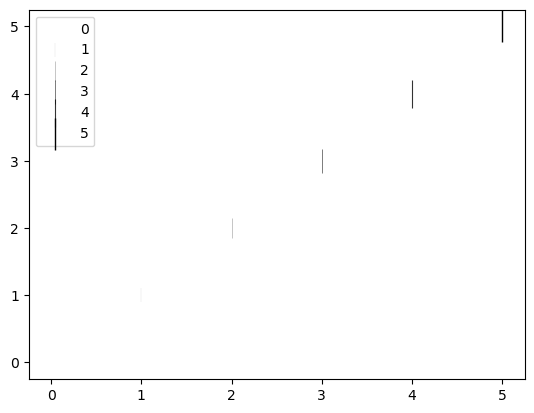

In [29]:
counts = np.array([0, 1, 2, 3, 4, 5])
for c in counts:
    plt.scatter(c, c, c * 100, marker="|", alpha=c / 5, linewidth=c / 5, color="black", label=c)
legend = plt.legend()
plt.show()

In [ ]:
legend.

{matplotlib.container.StemContainer: <matplotlib.legend_handler.HandlerStem at 0x151cd1f6f8e0>,
 matplotlib.container.ErrorbarContainer: <matplotlib.legend_handler.HandlerErrorbar at 0x151cd1f6f970>,
 matplotlib.lines.Line2D: <matplotlib.legend_handler.HandlerLine2D at 0x151cd1f6fa00>,
 matplotlib.patches.Patch: <matplotlib.legend_handler.HandlerPatch at 0x151cd1f6faf0>,
 matplotlib.patches.StepPatch: <matplotlib.legend_handler.HandlerStepPatch at 0x151cd1f6fc40>,
 matplotlib.collections.LineCollection: <matplotlib.legend_handler.HandlerLineCollection at 0x151cd1f6ff40>,
 matplotlib.collections.RegularPolyCollection: <matplotlib.legend_handler.HandlerRegularPolyCollection at 0x151cd1fa0760>,
 matplotlib.collections.CircleCollection: <matplotlib.legend_handler.HandlerCircleCollection at 0x151cd1fa0790>,
 matplotlib.container.BarContainer: <matplotlib.legend_handler.HandlerPatch at 0x151cd1fa07c0>,
 tuple: <matplotlib.legend_handler.HandlerTuple at 0x151cd1fa0820>,
 matplotlib.collection

TypeError: 'Legend' object is not iterable

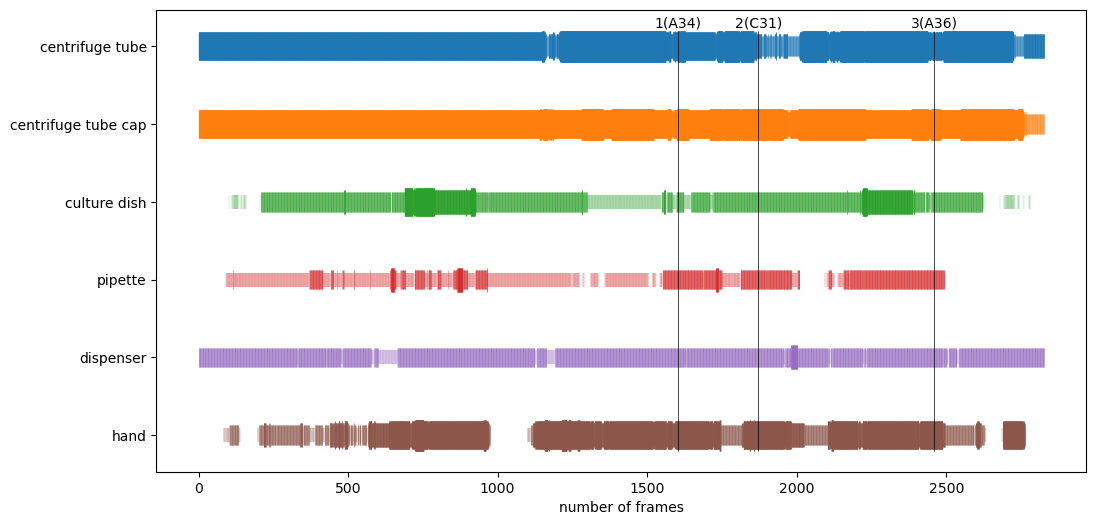

In [ ]:
max_n_counts = 5
plt.figure(figsize=(12, 6))

# plot object counts
for label, counts in counts_dict.items():
    y = np.full((len(counts),), len(classes) - (label + 1))
    x = np.arange(len(counts))
    counts = np.array(counts).astype(float)
    counts[counts > max_n_counts] = max_n_counts
    s = counts * 100
    alpha = (counts + 1) / (max_n_counts + 1)
    plt.scatter(
        x, y, label=classes[str(label)], marker="|", s=s, alpha=alpha, linewidths=alpha
    )

# plot annotation timing
for label, n_frame in ann_timings.items():
    plt.vlines([n_frame], -0.2, len(classes) - 1 + 0.2, color="black", lw=0.5)
    plt.text(n_frame, len(classes) - 1 + 0.25, label, horizontalalignment="center")

plt.xlabel("number of frames")
ticks = [len(classes) - (int(k) + 1) for k in classes.keys()]
plt.yticks(ticks, list(classes.values()))

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([], [], c="black", marker="|", ms=0 * 2, lw=0.0, alpha=0.0, label="0"),
    Line2D([], [], c="black", marker="|", ms=2 * 2, lw=0.0, alpha=0.2, label="1"),
    Line2D([], [], c="black", marker="|", ms=4 * 2, lw=0.0, alpha=0.4, label="2"),
    Line2D([], [], c="black", marker="|", ms=6 * 2, lw=0.0, alpha=0.6, label="3"),
    Line2D([], [], c="black", marker="|", ms=8 * 2, lw=0.0, alpha=0.8, label="4"),
    Line2D([], [], c="black", marker="|", ms=10 * 2, lw=0.0, alpha=1.0, label="5~"),
]
plt.legend(
    handles=legend_elements, bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=10
)

plt.legend(legend)
plt.show()

# TODO: 動き有りバージョン

max_n_counts 6


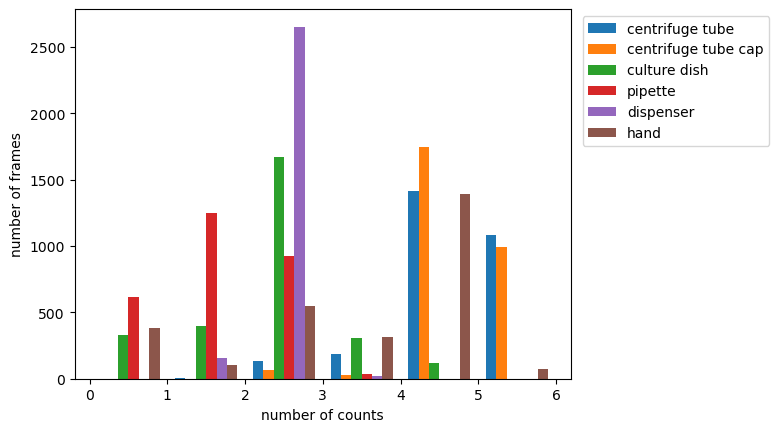

In [ ]:
max_n_counts = 0
for counts in counts_dict.values():
    if np.max(counts) > max_n_counts:
        max_n_counts = np.max(counts)
print("max_n_counts", max_n_counts)

# plt.figure(figsize=(8, 4))
counts_hist = np.array(list(counts_dict.values())).T
labels = list(classes.values())
plt.hist(counts_hist, bins=max_n_counts, range=(0, max_n_counts), label=labels)
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
plt.xlabel("number of counts")
plt.ylabel("number of frames")
plt.show()

In [1]:
# TODO　物体ごとに動いているかどうかのヒストグラム
# TODO 物体ごとに3Dグラフにする

# 異常発生場所のアノテーションと物体認識結果の分析
- 異常発生時とそうでない時の物体の配置の分布の違い
- 異常発生までの各物体の移動経路

In [8]:
ann_frames = {ann_label: None for ann_label in ann_unique_labels}

cap = video.Capture(f"video/{video_name}.mp4")
for ann_label, n_frame in ann_timings.items():
    cap.set_pos_frame_count(n_frame)
    ret, frame = cap.read()
    if ret == False:
        raise ValueError
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ann_frames[ann_label] = frame

del cap